In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import shap # For model interpretability


In [9]:
import pandas as pd
import numpy as np

# --- 1. Load Data and Standardize Name to 'df' ---
file_path = '../data/MachineLearningRating_v3.txt' 
df = pd.read_csv(file_path, sep='|', low_memory=False)

# Re-apply the column cleanup
df.columns = df.columns.str.strip().str.replace('[^A-Za-z0-9_]+', '_', regex=True).str.lower()

# --- 2. Final Cleaning and KPI Creation ---
# Coerce financial columns to numeric and handle NaNs
financial_cols = ['totalpremium', 'totalclaims', 'customvalueestimate', 'calculatedpremiumperterm', 'suminsured']
for col in financial_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=financial_cols, inplace=True)

# Create the binary 'claimed' KPI (used for classification)
df['claimed'] = np.where(df['totalclaims'] > 0, 1, 0)


# --- 3. Create the Claims-Only Subset (df_severity) ---
# Used exclusively for the Regression model (Claim Severity)
df_severity = df[df['claimed'] == 1].copy()

print(f"Main policies (df) defined: {len(df)}")
print(f"Claims-only policies (df_severity) defined: {len(df_severity)}")

Main policies (df) defined: 220456
Claims-only policies (df_severity) defined: 659


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Features defined in the previous step:
FEATURES = ['province', 'vehiclemodel', 'vehicletype', 'age', 'maritalstatus', 'customvalueestimate', 'totalpremium'] 

# Define column types based on your data:
numerical_features = ['age', 'customvalueestimate', 'totalpremium']
categorical_features = ['province', 'vehiclemodel', 'vehicletype', 'maritalstatus'] 

# Create the preprocessing steps
# Note: Imputation (handling missing data) is implicitly handled by converting NaNs to 0s or by dropping them 
# during the initial cleaning, but for robust production code, you would add SimpleImputer() here.
preprocessor = ColumnTransformer(
    transformers=[
        # 1. Numerical: Standardize features (mean=0, std=1)
        ('num', StandardScaler(), numerical_features),
        
        # 2. Categorical: One-Hot Encode (handling unseen categories)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop' 
)

In [7]:
print(df_severity.columns.tolist())

['underwrittencoverid', 'policyid', 'transactionmonth', 'isvatregistered', 'citizenship', 'legaltype', 'title', 'language', 'bank', 'accounttype', 'maritalstatus', 'gender', 'country', 'province', 'postalcode', 'maincrestazone', 'subcrestazone', 'itemtype', 'mmcode', 'vehicletype', 'registrationyear', 'make', 'model', 'cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'numberofdoors', 'vehicleintrodate', 'customvalueestimate', 'alarmimmobiliser', 'trackingdevice', 'capitaloutstanding', 'newvehicle', 'writtenoff', 'rebuilt', 'converted', 'crossborder', 'numberofvehiclesinfleet', 'suminsured', 'termfrequency', 'calculatedpremiumperterm', 'excessselected', 'covercategory', 'covertype', 'covergroup', 'section', 'product', 'statutoryclass', 'statutoryrisktype', 'totalpremium', 'totalclaims', 'claimed']


In [11]:
# --- REVISED FEATURES LIST ---
# Removed 'age' (not found) and replaced 'vehiclemodel' with 'model'
FEATURES = [
    'province', 
    'model', 
    'vehicletype', 
    'maritalstatus', 
    'customvalueestimate', 
    'totalpremium'
] 

# 1. Claim Severity Prediction (Regression on df_severity)
X_severity = df_severity[FEATURES].copy()
Y_severity = df_severity['totalclaims']

# 2. Claim Probability Prediction (Classification on df)
X_probability = df[FEATURES].copy()
Y_probability = df['claimed'] 

print("Features and Targets successfully defined for both models.")

Features and Targets successfully defined for both models.


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# --- 1. Define Features and Preprocessing Pipeline ---

# Features selected after correcting the KeyError:
FEATURES = ['province', 'model', 'vehicletype', 'maritalstatus', 'customvalueestimate', 'totalpremium'] 

# Separate features into Numerical (for Scaling) and Categorical (for Encoding)
numerical_features = ['customvalueestimate', 'totalpremium'] 
categorical_features = ['province', 'model', 'vehicletype', 'maritalstatus'] 

# Note: 'model' has very high cardinality (many unique values) which might slow down or bloat the model.
# We will rely on the OneHotEncoder's 'handle_unknown' to manage this complexity for now.

preprocessor = ColumnTransformer(
    transformers=[
        # Numerical features: Standardize (mean=0, std=1)
        ('num', StandardScaler(), numerical_features),
        
        # Categorical features: One-Hot Encode (creating binary columns)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop' # Drop any columns not used as features
)


# --- 2. Train-Test Splits (70:30 Ratio) ---

# A. Claim Severity Data Split (Regression Goal)
X_severity = df_severity[FEATURES].copy()
Y_severity = df_severity['totalclaims']

X_train_sev, X_test_sev, Y_train_sev, Y_test_sev = train_test_split(
    X_severity, 
    Y_severity, 
    test_size=0.3, 
    random_state=42
)

# B. Claim Probability Data Split (Classification Goal)
X_probability = df[FEATURES].copy()
Y_probability = df['claimed'] 

X_train_prob, X_test_prob, Y_train_prob, Y_test_prob = train_test_split(
    X_probability, 
    Y_probability, 
    test_size=0.3, 
    random_state=42,
    # IMPORTANT: Use stratify due to extreme class imbalance (~0.3% claims)
    stratify=Y_probability 
)

print(f"Severity Train/Test Split (Claims Only): {len(X_train_sev)} / {len(X_test_sev)}")
print(f"Probability Train/Test Split (All Data): {len(X_train_prob)} / {len(X_test_prob)}")

Severity Train/Test Split (Claims Only): 461 / 198
Probability Train/Test Split (All Data): 154319 / 66137


In [13]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Create the full Regression pipeline
severity_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        random_state=42
    ))
])

# Train the model
severity_pipeline.fit(X_train_sev, Y_train_sev)

# Predict and Evaluate
Y_pred_sev = severity_pipeline.predict(X_test_sev)

rmse_sev = np.sqrt(mean_squared_error(Y_test_sev, Y_pred_sev))
r2_sev = r2_score(Y_test_sev, Y_pred_sev)

print("\n--- Claim Severity (Regression) Results ---")
print(f"RMSE (Target: TotalClaims): {rmse_sev:.2f}")
print(f"R-squared (Variance Explained): {r2_sev:.4f}")


--- Claim Severity (Regression) Results ---
RMSE (Target: TotalClaims): 44318.81
R-squared (Variance Explained): -0.0069


In [14]:
from sklearn.metrics import f1_score

# Calculate the imbalance ratio for XGBoost (Weight of the positive class)
# This is crucial because only ~0.3% of policies have claims.
scale_pos_weight = (Y_train_prob == 0).sum() / (Y_train_prob == 1).sum()

# Create the full Classification pipeline
probability_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])

# Train the model
probability_pipeline.fit(X_train_prob, Y_train_prob)

# Predict and Evaluate
Y_pred_prob_class = probability_pipeline.predict(X_test_prob)

f1_prob = f1_score(Y_test_prob, Y_pred_prob_class)

print("\n--- Claim Probability (Classification) Results ---")
print(f"F1-Score (Balance of Precision/Recall): {f1_prob:.4f}")

c:\Users\Her\Desktop\Week-3\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:07:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Claim Probability (Classification) Results ---
F1-Score (Balance of Precision/Recall): 0.0297


In [15]:
import pandas as pd
import numpy as np

# --- 1. Load Data and Standardize Name to 'df' ---
file_path = '../data/MachineLearningRating_v3.txt' 
# Assuming you have solved the module/path errors for loading the data
df = pd.read_csv(file_path, sep='|', low_memory=False)

# Re-apply the column cleanup (to ensure lowercase names)
df.columns = df.columns.str.strip().str.replace('[^A-Za-z0-9_]+', '_', regex=True).str.lower()

# --- 2. Final Cleaning and KPI Creation ---
# Coerce financial columns to numeric and handle NaNs
financial_cols = ['totalpremium', 'totalclaims', 'customvalueestimate', 'calculatedpremiumperterm', 'suminsured']
for col in financial_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=financial_cols, inplace=True)

# Create the binary 'claimed' KPI
df['claimed'] = np.where(df['totalclaims'] > 0, 1, 0)

# --- 3. Create the Claims-Only Subset (df_severity) ---
# This is the line that defines the missing variable!
df_severity = df[df['claimed'] == 1].copy()

print(f"Dataframes df and df_severity are now defined.")

Dataframes df and df_severity are now defined.


In [16]:
# Assuming 'df' and 'FEATURES' are already defined, and imports are run.
from sklearn.model_selection import train_test_split

# --- A. Claim Severity Data Split (Regression Goal) ---
X_severity = df_severity[FEATURES].copy()
Y_severity = df_severity['totalclaims']

X_train_sev, X_test_sev, Y_train_sev, Y_test_sev = train_test_split(
    X_severity, 
    Y_severity, 
    test_size=0.3, 
    random_state=42
)

# --- B. Claim Probability Data Split (Classification Goal) ---
X_probability = df[FEATURES].copy()
Y_probability = df['claimed'] 

X_train_prob, X_test_prob, Y_train_prob, Y_test_prob = train_test_split(
    X_probability, 
    Y_probability, 
    test_size=0.3, 
    random_state=42,
    # IMPORTANT: Use stratify due to extreme class imbalance (~0.3% claims)
    stratify=Y_probability 
)

print(f"Probability Train/Test Split (All Data): {len(X_train_prob)} / {len(X_test_prob)}")

Probability Train/Test Split (All Data): 154319 / 66137


In [17]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# --- Define Preprocessor (If not already defined) ---
# You need this block to ensure 'preprocessor' is defined for the pipelines
numerical_features = ['customvalueestimate', 'totalpremium'] 
categorical_features = ['province', 'model', 'vehicletype', 'maritalstatus'] 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop' 
)

# --- Claim Severity Model Training ---

# Create the full Regression pipeline
severity_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        random_state=42
    ))
])

# Train the model (Assuming X_train_sev and Y_train_sev are defined)
severity_pipeline.fit(X_train_sev, Y_train_sev)

# Predict and Evaluate (Optional, but good for verification)
Y_pred_sev = severity_pipeline.predict(X_test_sev)

rmse_sev = np.sqrt(mean_squared_error(Y_test_sev, Y_pred_sev))
r2_sev = r2_score(Y_test_sev, Y_pred_sev)

print("Severity Model Training Complete.")
print(f"R-squared: {r2_sev:.4f}")

Severity Model Training Complete.
R-squared: -0.0069


SHAP values calculated. Generating summary plot...


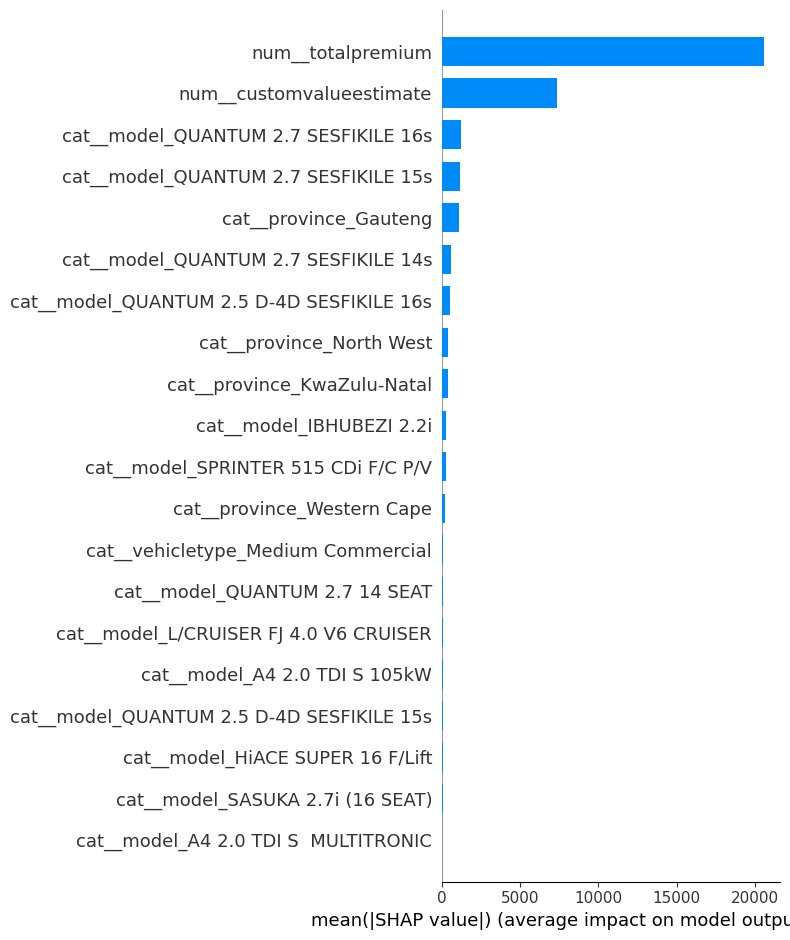

In [18]:
import shap

# Access the fitted preprocessor and the fitted XGBoost model
fitted_preprocessor = severity_pipeline.named_steps['preprocessor']
fitted_xgb_model = severity_pipeline.named_steps['regressor']

# Transform the test data to get the feature names and the preprocessed array
X_test_processed = fitted_preprocessor.transform(X_test_sev)

# Get the processed feature names
feature_names = fitted_preprocessor.get_feature_names_out().tolist()

# 1. Create a SHAP Explainer (TreeExplainer is specific for tree models)
explainer = shap.TreeExplainer(fitted_xgb_model)

# 2. Calculate SHAP values
shap_values = explainer.shap_values(X_test_processed)

print("SHAP values calculated. Generating summary plot...")

# 3. Create a SHAP Summary Plot
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, plot_type="bar")